# Plot SWE From Pits 

**Goal**: Calculate SWE from the Density Profiles and plot them

**Approach**:

1. Grab All the site ids and dates associated to all the density data
2. Calculate SWE for each layer and sum them up 
3. plot it!


## Process 


### Step 1. Grab all Density profiles and Calculate SWE

In [1]:
from snowxsql.data import LayerData
from snowxsql.db import get_db
from snowxsql.conversions import query_to_geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
from geoalchemy2.shape import to_shape
import pandas as pd

# Connect to the database we made.
db_name = 'snowex'
engine, session = get_db(db_name)
q = session.query(LayerData).filter(LayerData.type == 'density')
df = query_to_geopandas(q, engine)

# Convert density to float
df['value'] = df['value'].astype(float)

# Calculate SWE
swe_lambda = lambda row: row['value'] * (row['depth'] - row['bottom_depth']) / 100
df['swe'] = df.apply(swe_lambda, axis=1)


### Step 2. Prepare SWE as point data

In [2]:
# Prepare the data to be a single point by summing the SWE by site and date
point_swe = gpd.GeoDataFrame(columns=['date', 'swe', 'geometry'])

sites = df['site_id'].unique().tolist()

# Loop over data by site and date
for site in sites:
    ind1 = df['site_id'] == site
    dates = df['date'][ind1].unique().tolist()

    for date in dates:
        # Grab all density at this site and date
        ind2= df['date'] == date
        
        profile = df[ind1 & ind2]
                
        # Check if there is data on this date/site
        if len(profile.index) > 0:

            # sum the swe column and assign data to a dictionary
            data = {'swe': profile['swe'].sum(), 'geometry': profile['geom'].iloc[0], 'date': date}

            # Add the data to a dataframe
            point_swe = point_swe.append(data, ignore_index=True)


### Step 3. Plot the SWE as points coloring by mass

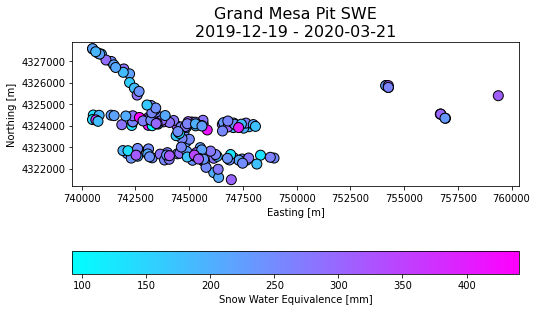

In [3]:
# Build a singl plot
fig, ax = plt.subplots(figsize=(8,8))

# Colorbar keyword arguments
kwds = {'label': "Snow Water Equivalence [mm]", 'orientation': "horizontal"}

# Plot it all up as a scatter using SWE as the color
ax = point_swe.plot(ax=ax, column='swe', cmap='cool', markersize=100, legend=True, edgecolor='k',legend_kwds=kwds)

# Set some style/ labeling choices
ax.ticklabel_format(style='plain', useOffset=False)
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')

title = 'Grand Mesa Pit SWE\n{} - {}'.format(point_swe['date'].min(), point_swe['date'].max())
ax.set_title(title, fontsize=16)

plt.show()

In [ ]:
# Close the session to avoid hanging transactions
session.close()